In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

## Logistic regression

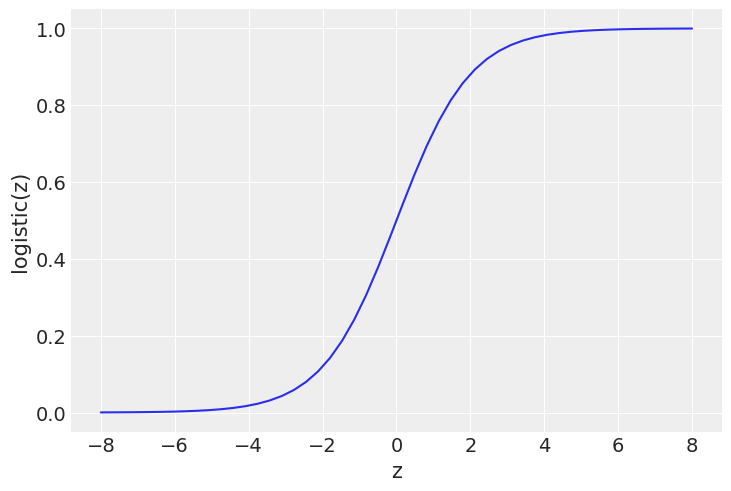

In [3]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.savefig('B11197_04_01.png', dpi=300);

## The iris dataset

In [4]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


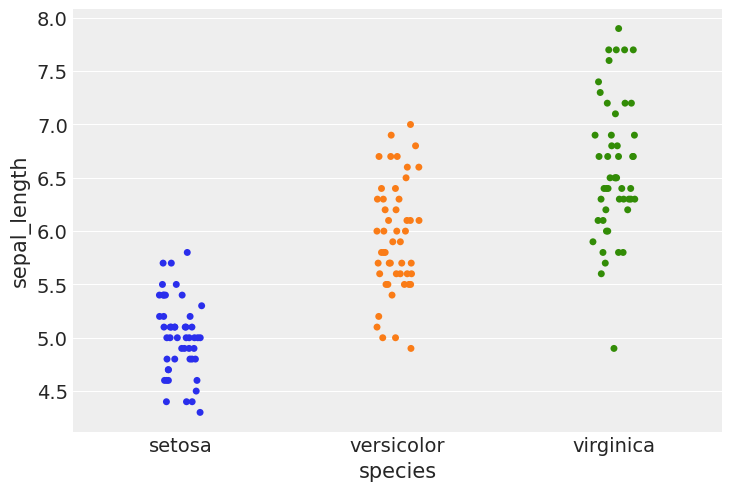

In [5]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.savefig('B11197_04_02.png', dpi=300);

/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


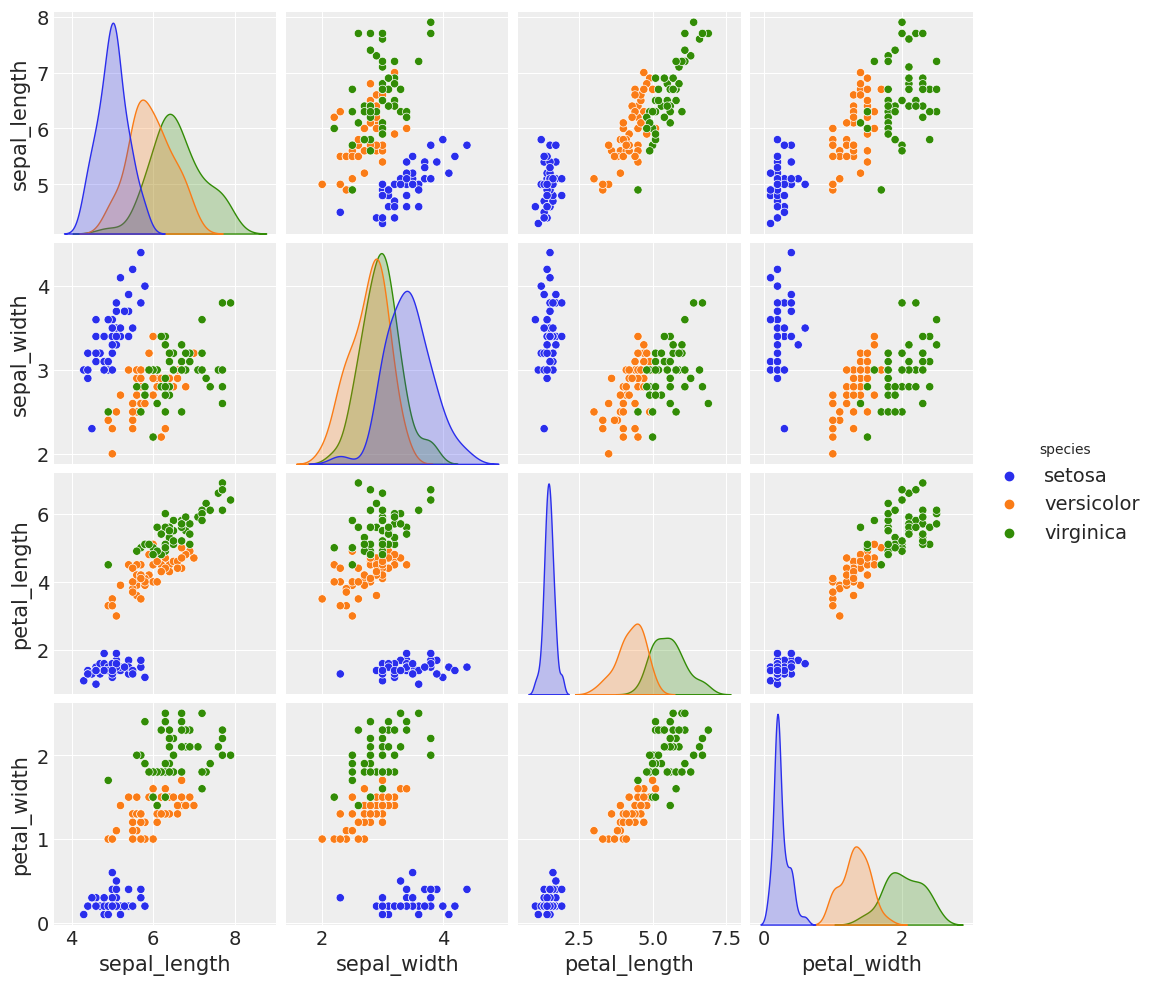

In [6]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.savefig('B11197_04_03.png', dpi=300, bbox_inches='tight');

### The logistic model applied to the iris dataset

In [8]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [9]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    idata_0 = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [10]:
varnames = ['α', 'β', 'bd']
az.summary(idata_0, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.295,0.337,-0.325,0.916,0.006,0.005,2870.0,2110.0,1.0
β,5.378,1.053,3.444,7.297,0.020,0.015,2807.0,2551.0,1.0
bd,-0.054,0.062,-0.164,0.069,0.001,0.001,2982.0,2387.0,1.0


/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


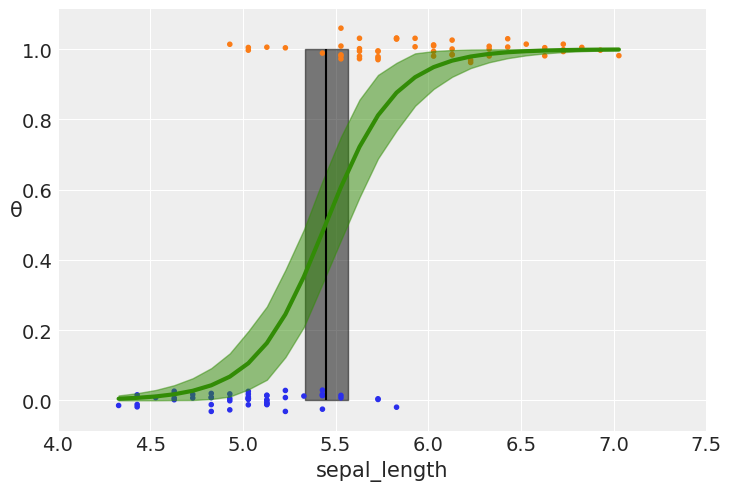

In [11]:
posterior_0 = idata_0.posterior.stack(samples=("chain", "draw"))

theta = posterior_0['θ'].mean("samples")
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(posterior_0['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, posterior_0['θ'].T, color='C2', smooth=False)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_04.png', dpi=300)

# Multiple logistic regression

In [12]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [13]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    idata_1 = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


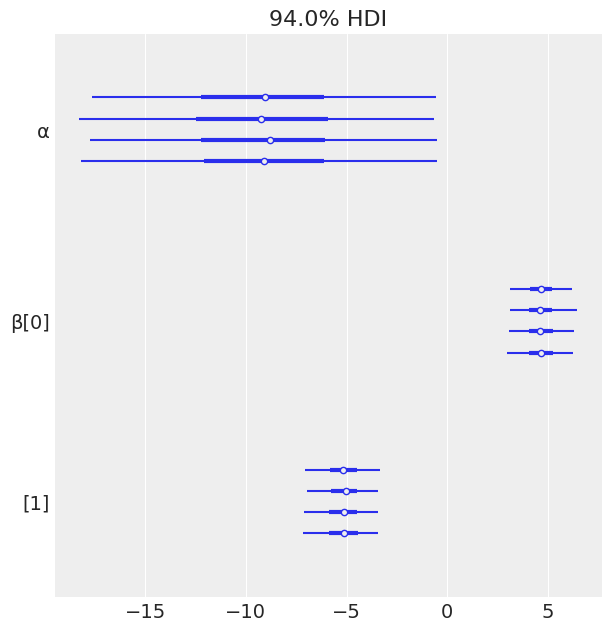

In [14]:
varnames = ['α', 'β'] 
az.plot_forest(idata_1, var_names=varnames);

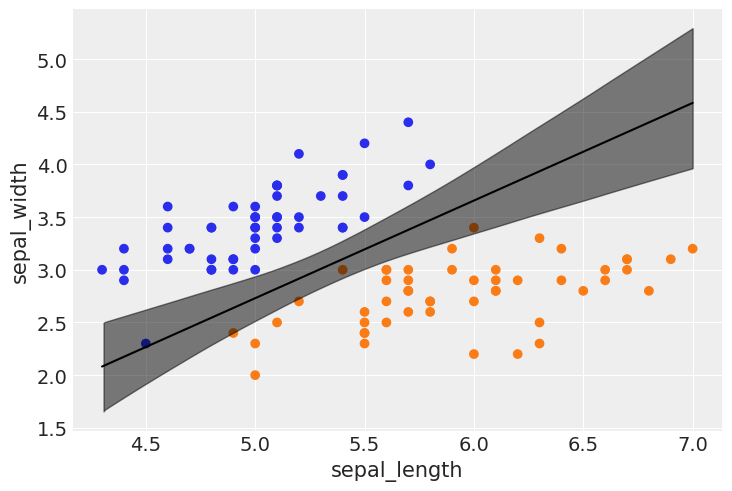

In [16]:
idx = np.argsort(x_1[:,0]) 
bd = idata_1.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hdi(x_1[:,0], idata_1.posterior['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
plt.savefig('B11197_04_05.png', dpi=300);

## Interpreting the coefficients of a logistic regression

/var/folders/41/m4p4wr2x7vndp1mqbq054v88h6hkrl/T/ipykernel_37563/23236795.py:2: RuntimeWarning: divide by zero encountered in true_divide
  odds = probability / (1 - probability)


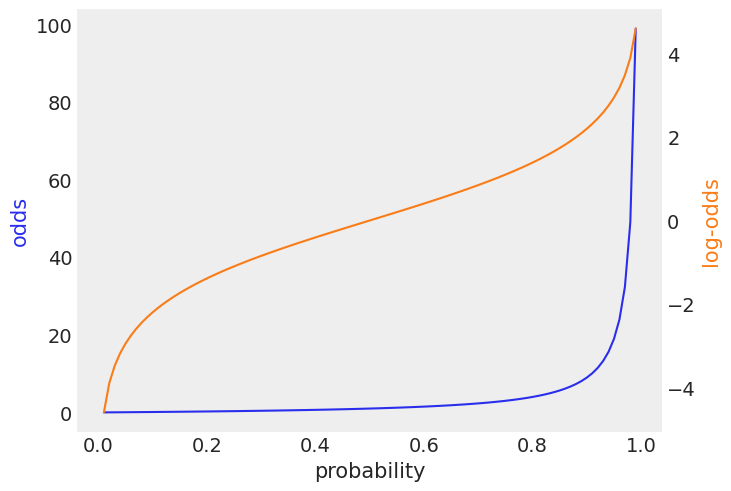

In [17]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)
plt.savefig('B11197_04_06.png', dpi=300);

In [18]:
df = az.summary(idata_1, var_names=varnames)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-9.179,4.628,-17.560,-0.075,0.093,0.070,2469.0,2559.0,1.0
β[0],4.672,0.867,3.113,6.349,0.017,0.012,2520.0,2691.0,1.0
β[1],-5.177,1.000,-7.106,-3.434,0.020,0.014,2626.0,2912.0,1.0


In [19]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

f"{log_odds_versicolor_f - log_odds_versicolor_i:.2f}", f"{probability_versicolor_f - probability_versicolor_i:.2f}"

('4.67', '0.70')

## Dealing with correlated variables

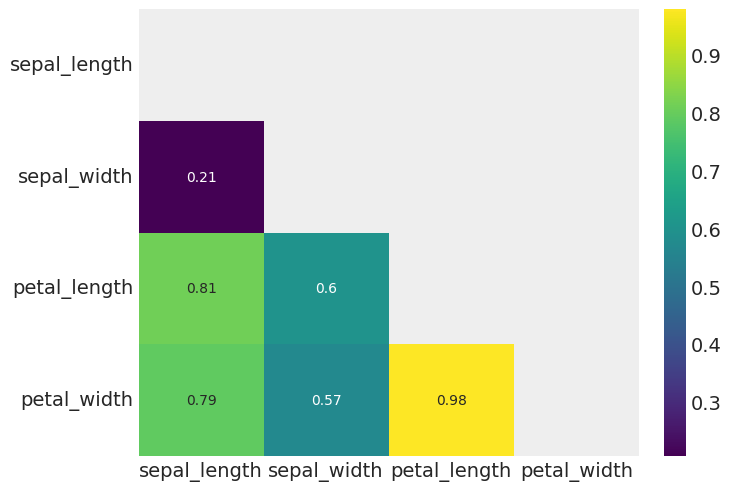

In [20]:
corr = iris[iris['species'] != 'virginica'].corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
plt.savefig('B11197_04_07.png', dpi=300, bbox_inches='tight');

## Dealing with unbalanced classes

In [21]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [22]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    idata_3 = pm.sample(1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [23]:
#az.plot_trace(idata_3, varnames);

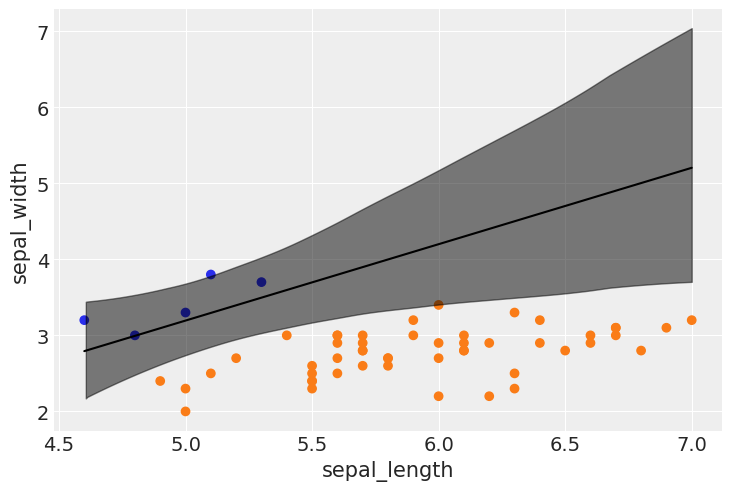

In [24]:
idx = np.argsort(x_3[:,0]) 
bd = idata_3.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hdi(x_3[:,0], idata_3.posterior['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

plt.savefig('B11197_04_08.png', dpi=300);

## Softmax regression

In [25]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [26]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_s = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.


In [27]:
#az.plot_forest(trace_s, var_names=['α', 'β']);

In [28]:
data_pred = idata_s.posterior['μ'].mean(("chain", "draw"))

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]

f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [29]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_sf = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


## Discriminative and generative models

In [30]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sd=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ,
                           observed=x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    idata_lda = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


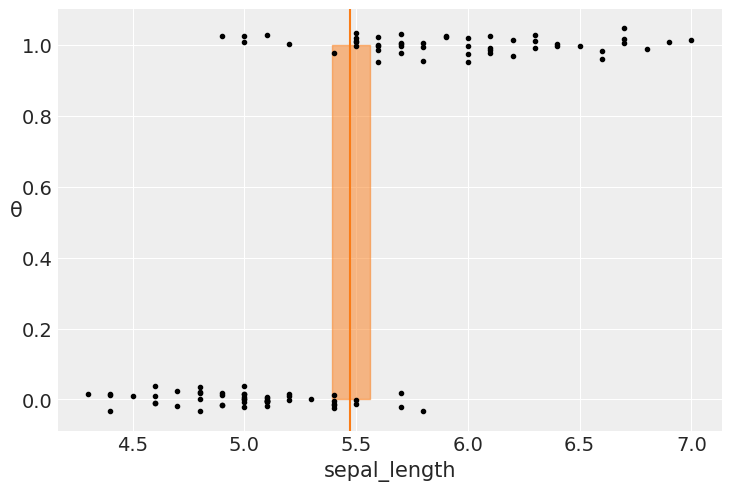

In [31]:
posterior_lda = idata_lda.posterior.stack(samples=("chain", "draw"))
plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.savefig('B11197_04_09.png', dpi=300)

In [32]:
az.summary(idata_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],5.007,0.065,4.889,5.131,0.001,0.001,4742.0,2677.0,1.0
μ[1],5.935,0.065,5.809,6.050,0.001,0.001,5267.0,2944.0,1.0
σ,0.448,0.033,0.387,0.510,0.000,0.000,4747.0,2853.0,1.0
bd,5.471,0.045,5.390,5.560,0.001,0.000,4900.0,3002.0,1.0


### The Poisson distribution

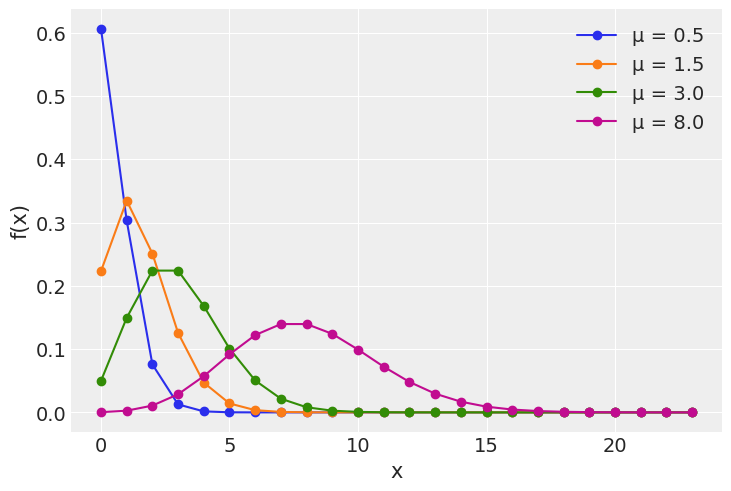

In [33]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('B11197_04_10.png', dpi=300);

## The Zero-Inflated Poisson model

In [34]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * 
                   np.random.poisson(θ_real) for i in range(n)])

In [39]:
counts

array([0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ,
                               observed=counts)
    idata = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


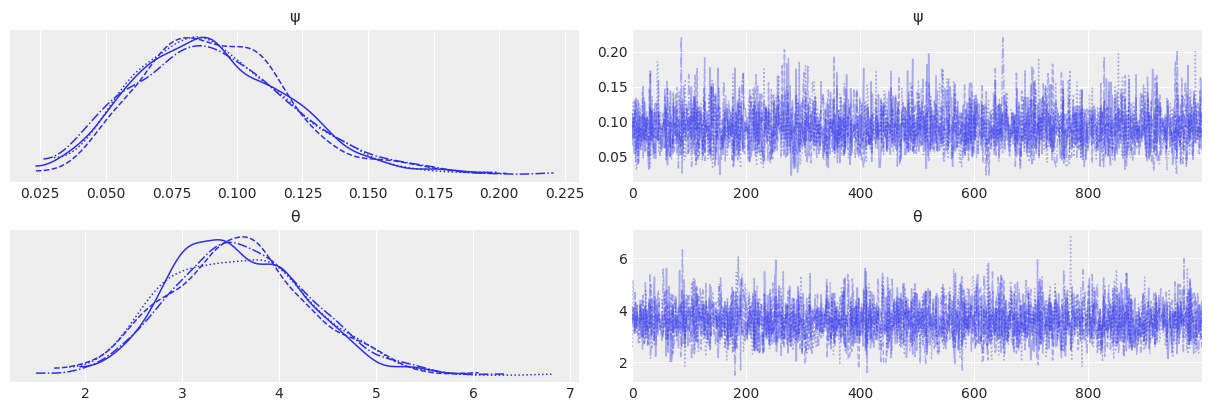

In [40]:
az.plot_trace(idata)
plt.savefig('B11197_04_11.png', dpi=300);

In [36]:
#az.summary(idata)

## Poisson regression and ZIP regression

In [41]:
fish_data = pd.read_csv('../data/fish.csv')

In [42]:
fish_data

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1
...,...,...,...,...,...,...,...,...
245,1,1,1,2,0,-0.755236,2.324209,0
246,0,1,1,4,3,1.794859,-5.625944,0
247,0,1,1,2,1,-0.392649,0.677275,0
248,1,1,1,3,2,1.374641,-2.595630,0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


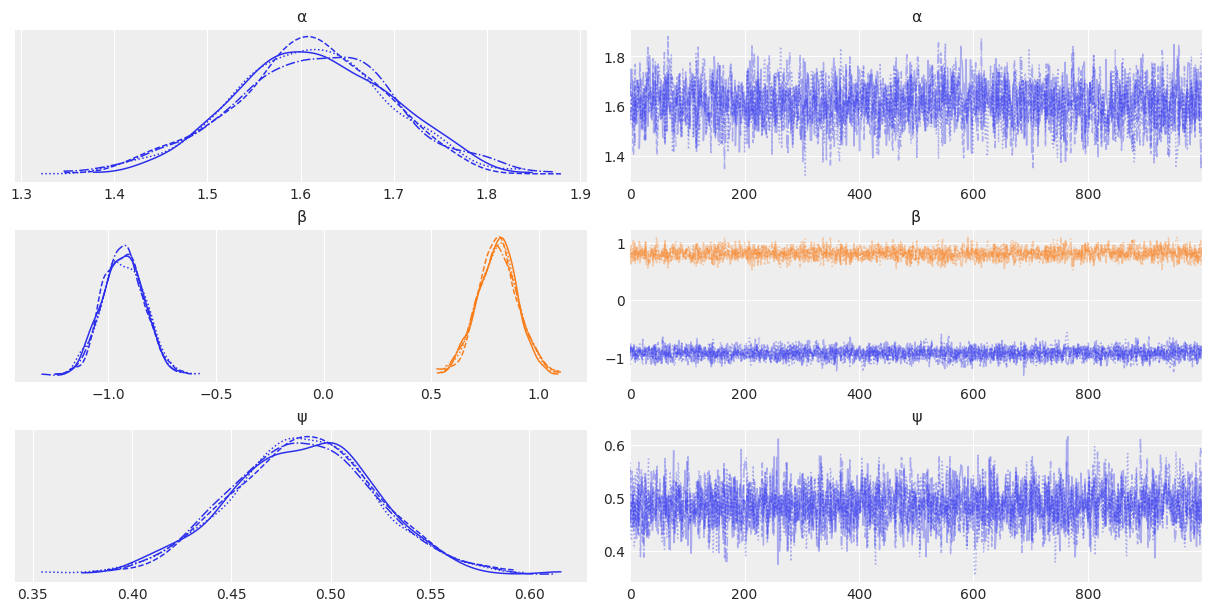

In [43]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    idata_ZIP_reg = pm.sample(1000, return_inferencedata=True)
az.plot_trace(idata_ZIP_reg);

In [44]:
az.summary(idata_ZIP_reg)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.610,0.085,1.440,1.762,0.002,0.001,2132.0,2237.0,1.0
β[0],-0.930,0.096,-1.107,-0.753,0.002,0.001,3052.0,2745.0,1.0
β[1],0.809,0.093,0.634,0.989,0.002,0.001,2073.0,2076.0,1.0
ψ,0.486,0.037,0.417,0.554,0.001,0.000,2802.0,2723.0,1.0


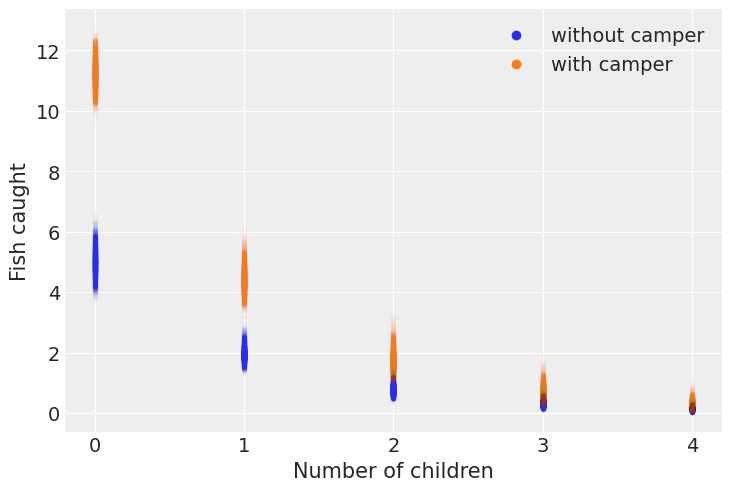

In [45]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

posterior_ZIP_reg = idata_ZIP_reg.posterior.stack(samples=("chain", "draw"))

for n in children:
    without_camper = posterior_ZIP_reg['α'] + posterior_ZIP_reg['β'].values[0] * n
    with_camper = without_camper + posterior_ZIP_reg['β'].values[1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
plt.savefig('B11197_04_12.png', dpi=300);

## Robust logistic regression

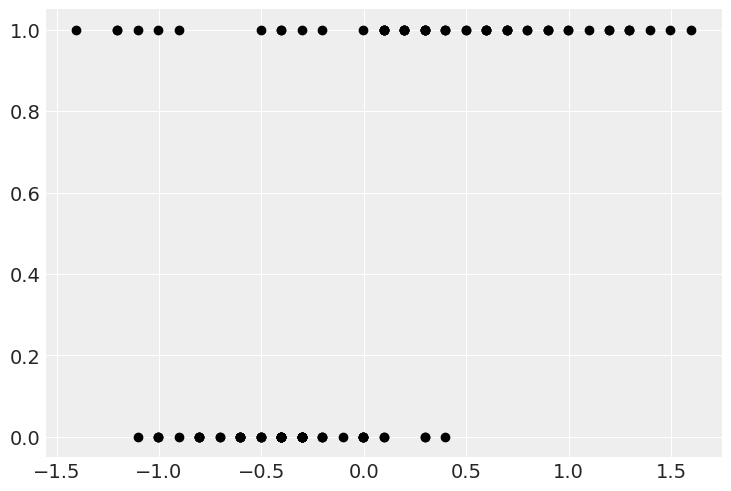

In [46]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

In [47]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1., 1.) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    idata_rlg = pm.sample(1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


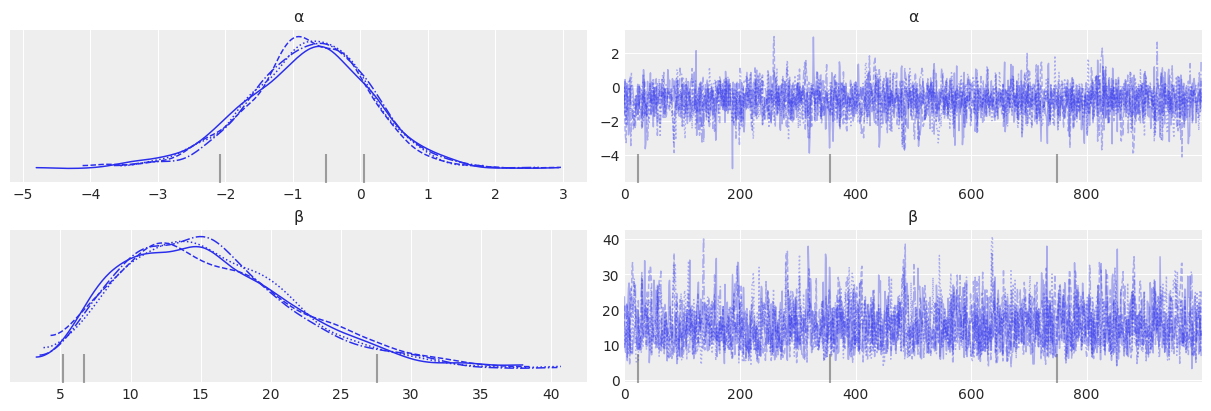

In [48]:
az.plot_trace(idata_rlg, varnames);

In [49]:
varnames = ['α', 'β', 'bd']
az.summary(idata_rlg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.769,0.909,-2.504,0.887,0.020,0.015,2095.0,1988.0,1.0
β,15.597,6.128,5.128,26.787,0.153,0.109,1655.0,2008.0,1.0
bd,0.047,0.059,-0.067,0.150,0.001,0.001,2891.0,2417.0,1.0


/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


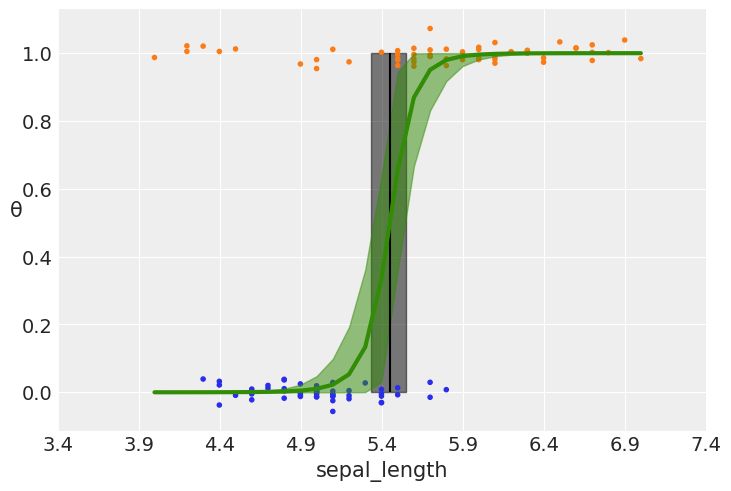

In [50]:
posterior_rlg = idata_rlg.posterior.stack(samples=("chain", "draw"))

theta = posterior_rlg['θ'].mean("samples")
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_rlg['bd'].mean(), 0, 1, color='k')
bd_hdi = az.hdi(posterior_rlg['bd'].values)
plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, posterior_rlg['θ'].T, color='C2', smooth=False)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));